# Liquid biopsy benchmark

In [31]:
# Imports

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, roc_auc_score, precision_score, recall_score, average_precision_score
warnings.filterwarnings('ignore')
# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [32]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
#set_display_params(config)

fraction_list = ['', '_T40', '_T20'] # tumor purity 100%, 40% and 20%
f_list = [1, 0.4, 0.2]
samples = ['icgc_cll_tumour' , 'icgc_mbl_tumour']
purity_dict = {'icgc_cll_tumour': 0.92,  'icgc_mbl_tumour': 0.98} # source: Weitai
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}


dilutiondirpath = ["data", "dilutions_chr22"]
bcbiooutputdirpath = ["data", "bcbio_output"]
prefix = 'dilution_chr22_'
chrom = '22'
plasmasample1 = 'CRC-986_100215'
methods = ['freebayes', 'mutect2', 'strelka2', 'vardict', 'varscan']
#reference = 'CRC-986_300316'
reference = 'pooledhealthy'
#reference = 'pooledhealthy_986_filter_snv'
tumorsample1 = 'NCC_CRC-986_100215-T1W'

dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875)]
alpha_dict = {str(dilutionseries[i]): 1-0.15*i for i in range(len(dilutionseries))}
#alpha_list = [1, 1, .8, .6, .4, .2, 0.1]
#ls_list = ['solid', (0, (5, 1)), 'dashed', (0, (5, 10)), 'dotted', (0, (1, 10))]
#ls_dict = {str(dilutionseries[i]): ls_list[i] for i in range(len(dilutionseries))}
#lw_dict = {str(dilutionseries[i]): len(dilutionseries)-i for i in range(len(dilutionseries))}
print(alpha_dict)

tb_dict = {}
for i, d in enumerate(dilutionseries):
    tb_dict[str(dilutionseries[i])] = float(pd.read_csv(os.path.join(*dilutiondirpath, "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries[i][0])+"_"+reference+"_"+str(dilutionseries[i][1])+".txt")).columns[0])
tb_dict

{'(1, 0)': 1.0, '(1, 0.72)': 0.85, '(0.75, 0.765)': 0.7, '(0.5, 0.81)': 0.55, '(0.25, 0.855)': 0.4, '(0.125, 0.875)': 0.25}


{'(1, 0)': 0.41899930338493496,
 '(1, 0.72)': 0.08332118791365564,
 '(0.75, 0.765)': 0.06246857187258912,
 '(0.5, 0.81)': 0.04163090366877037,
 '(0.25, 0.855)': 0.02080792450423319,
 '(0.125, 0.875)': 0.01043106660067952}

# Precision Recall curve - SNV - Caller robustness: GT = calls detected by at least k callers in the undiluted sample

select a single chrom = 22 for analysis
(340, 1)
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(340, 16) (340, 1)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(153, 16) (340, 1)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(149, 16) (340, 1)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(146, 16) (340, 1)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(148, 16) (340, 1)


(-0.01, 1.01)

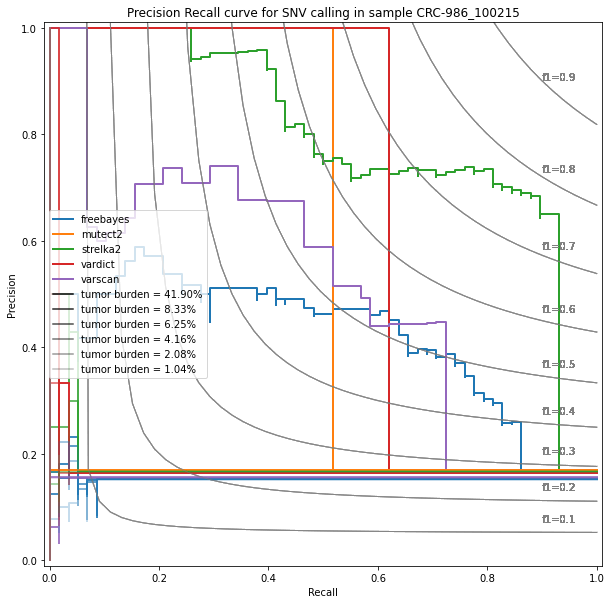

In [3]:
# GROUND TRUTH = consensus across 3 callers in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[methods].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)

# Sample of interest
fig, ax = plt.subplots(figsize=(10,10))
for i, d in enumerate(dilutionseries):
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    print('vcf_pd_'+str(i), d)
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    if vcf_sample is not None:
        vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
        print(vcf_sample.shape, y_true.shape)
        df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

        for method in config.methods:
            df_sample_method = df_sample[['truth', method + '_score']].dropna(how='all')
            #print(df_sample_method.shape)
            df_sample_method['truth'].fillna(False, inplace=True)
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            precision, recall, thresholds = precision_recall_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
            if i == 0:
                plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
            else:
                plot_pr_curve(precision, recall, estimator_name='', f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha': alpha_dict[str(d)], 'lw':2})
handles, labels = plt.gca().get_legend_handles_labels()
# Creating legend with color box
list_lines =  handles + [Line2D([0], [0], color='black', alpha=alpha_dict[str(i)], label='tumor burden = {:.2f}%'.format(100*tb_dict[str(i)])) for i in dilutionseries]
plt.legend(bbox_to_anchor=(1,1), loc="upper left", handles=list_lines)
plt.title("Precision Recall curve for SNV calling in sample {}".format(plasmasample1))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

select a single chrom = 22 for analysis
(340, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
Index(['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'freebayes', 'type',
       'freebayes_score', 'mutect2', 'mutect2_score', 'strelka2',
       'strelka2_score', 'vardict', 'vardict_score', 'varscan',
       'varscan_score'],
      dtype='object')
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
Index(['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'freebayes', 'type',
       'freebayes_score', 'mutect2', 'mutect2_score', 'strelka2',
       'strelka2_score', 'vardict', 'vardict_score', 'varscan',
       'varscan_score'],
      dtype='object')
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
Index(['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'freebayes', 'type',
       'freebayes_score', 'mutect2', 'mutect2_score', 'strelka2',
       'strelka2_score', 'vardict', 'vardict_score', 'varscan',
       'varscan_score'],
      dtype='object')
vcf_pd_3 (0

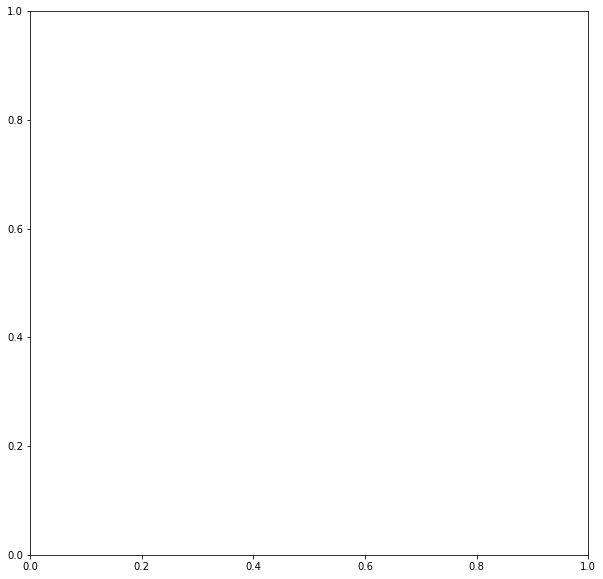

In [91]:
# GROUND TRUTH = consensus across 3 callers in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[methods].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)
df_table = y_true.copy()
print(df_table.columns)

# Sample of interest
for i, d in enumerate(dilutionseries):
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    print('vcf_pd_'+str(i), d)
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    if vcf_sample is not None:
        vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
        vcf_sample.rename(columns={m: str(round(100*tb_dict[str(d)], 3)) + '_'+ m for m in config.methods}, inplace=True)
        vcf_sample.rename(columns={m+ '_score' : str(round(100*tb_dict[str(d)], 3)) + '_'+ m + '_score' for m in config.methods}, inplace=True)
        colmerge = [str(round(100*tb_dict[str(d)], 3)) + '_' + m for m in config.methods] + [str(round(100*tb_dict[str(d)], 3)) + '_' + m + '_score' for m in config.methods]
        df_table = pd.concat([df_table, vcf_sample[colmerge]], axis=1)

(-0.01, 1.01)

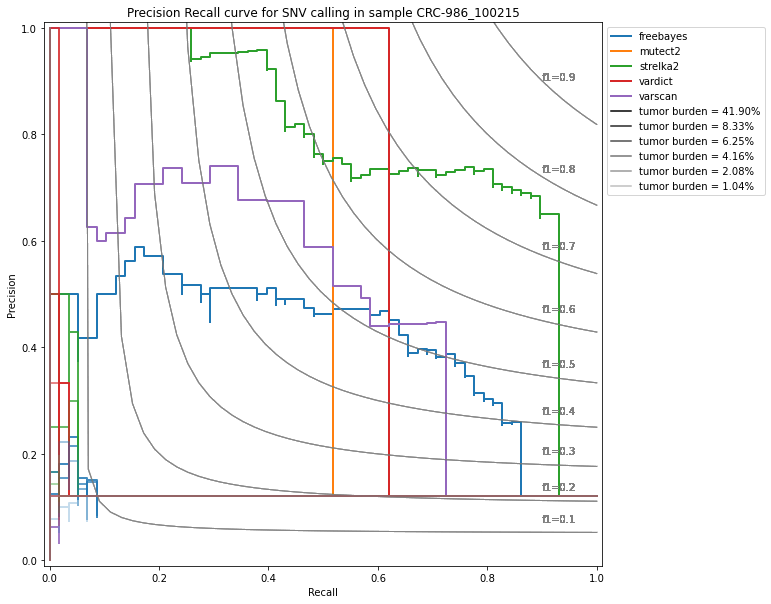

In [96]:
fig, ax = plt.subplots(figsize=(10,10))

for i, d in enumerate(dilutionseries):
    for method in config.methods:
        try:
            df_method = df_table[['truth', str(round(100*tb_dict[str(d)], 3)) + '_' + method + '_score']]
            df_method['truth'].fillna(False, inplace=True)
            df_method[str(round(100*tb_dict[str(d)], 3)) + '_' + method + '_score'].fillna(0, inplace=True)
            precision, recall, thresholds = precision_recall_curve(df_method['truth'], df_method[str(round(100*tb_dict[str(d)], 3)) + '_' + method + '_score'])
            if i == 0:
                plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
            else:
                plot_pr_curve(precision, recall, estimator_name='', f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha': alpha_dict[str(d)], 'lw':2})
        except:
            pass
handles, labels = plt.gca().get_legend_handles_labels()
# Creating legend with color box
list_lines =  handles + [Line2D([0], [0], color='black', alpha=alpha_dict[str(i)], label='tumor burden = {:.2f}%'.format(100*tb_dict[str(i)])) for i in dilutionseries]
plt.legend(bbox_to_anchor=(1,1), loc="upper left", handles=list_lines)
plt.title("Precision Recall curve for SNV calling in sample {}".format(plasmasample1))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

In [88]:
a = [str(round(100*tb_dict[str(d)], 3)) + '_' + m for m in config.methods]
a

['1.043_freebayes',
 '1.043_mutect2',
 '1.043_strelka2',
 '1.043_vardict',
 '1.043_varscan']

In [87]:
vcf_sample.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'QUAL', '1.043_freebayes', 'type',
       '1.043_freebayes_score', '1.043_mutect2', '1.043_mutect2_score',
       '1.043_strelka2', '1.043_strelka2_score', '1.043_vardict',
       '1.043_vardict_score', '1.043_varscan', '1.043_varscan_score'],
      dtype='object')

In [75]:
vcf_sample.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'QUAL', '8.332_freebayes', 'type',
       '8.332_freebayes_score', '8.332_mutect2', '8.332_mutect2_score',
       '8.332_strelka2', '8.332_strelka2_score', '8.332_vardict',
       '8.332_vardict_score', '8.332_varscan', '8.332_varscan_score'],
      dtype='object')

# ROC curve - SNV - Caller robustness: GT = calls detected by at least k callers in the undiluted sample

select a single chrom = 22 for analysis
(340, 1)
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(340, 16) (340, 1)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(153, 16) (340, 1)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(149, 16) (340, 1)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(146, 16) (340, 1)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(148, 16) (340, 1)


(-0.01, 1.01)

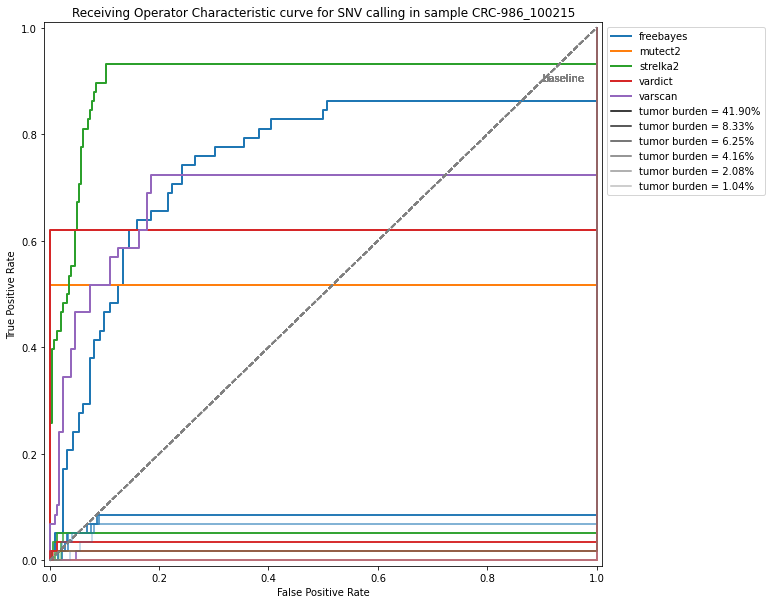

In [6]:
# GROUND TRUTH = consensus across 3 callers in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[methods].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)

# Sample of interest
fig, ax = plt.subplots(figsize=(10,10))
for i, d in enumerate(dilutionseries):
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    print('vcf_pd_'+str(i), d)
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    if vcf_sample is not None:
        vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
        print(vcf_sample.shape, y_true.shape)
        df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

        for method in config.methods:
            df_sample_method = df_sample[['truth', method + '_score']].dropna(how='all')
            #print(df_sample_method.shape)
            df_sample_method['truth'].fillna(False, inplace=True)
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            fpr, tpr, thresholds = roc_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
            if i == 0:
                plot_roc_curve(fpr, tpr, estimator_name=method, auc_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
            else:
                plot_roc_curve(fpr, tpr, estimator_name='', auc_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha': alpha_dict[str(d)], 'lw':2})
handles, labels = plt.gca().get_legend_handles_labels()
# Creating legend with color box
list_lines =  handles + [Line2D([0], [0], color='black', alpha=alpha_dict[str(i)], label='tumor burden = {:.2f}%'.format(100*tb_dict[str(i)])) for i in dilutionseries]
plt.legend(bbox_to_anchor=(1,1), loc="upper left", handles=list_lines)
plt.title("Receiving Operator Characteristic curve for SNV calling in sample {}".format(plasmasample1))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

# Precision Recall curve - SNV - Caller consistency: GT = calls detected by the same method in the undiluted sample

select a single chrom = 22 for analysis
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(340, 16)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(153, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(149, 16)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(146, 16)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(148, 16)


(-0.01, 1.01)

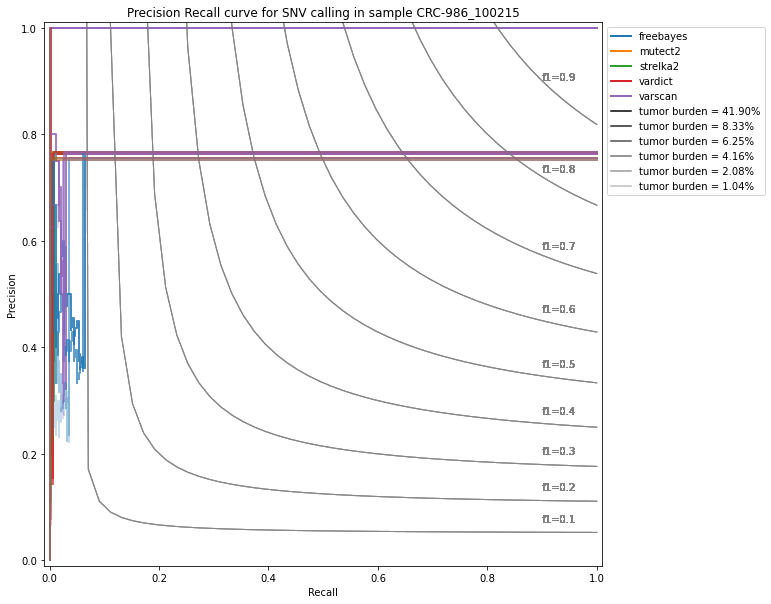

In [8]:
# Sample of interest
fig, ax = plt.subplots(figsize=(10,10))
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
for i, d in enumerate(dilutionseries):
    #if i == 0:
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    print('vcf_pd_'+str(i), d)
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    if vcf_sample is not None:
        vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
        print(vcf_sample.shape)

        for method in config.methods:
            # GROUND TRUTH = calls detected by same method in undiluted sample
            y_true = pd.DataFrame(vcf_ref[[method]])
            y_true.columns = ['truth']
            y_true = y_true.astype(bool)
            df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

            df_sample_method = df_sample[['truth', method + '_score']]
            df_sample_method['truth'].fillna(False, inplace=True)
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            precision, recall, thresholds = precision_recall_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
            if i == 0:
                plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
            else:
                plot_pr_curve(precision, recall, estimator_name='', f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
handles, labels = plt.gca().get_legend_handles_labels()
# Creating legend with color box
list_lines =  handles + [Line2D([0], [0], color='black', alpha=alpha_dict[str(i)], label='tumor burden = {:.2f}%'.format(100*tb_dict[str(i)])) for i in dilutionseries]
plt.legend(bbox_to_anchor=(1,1), loc="upper left", handles=list_lines)
plt.title("Precision Recall curve for SNV calling in sample {}".format(plasmasample1))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

# ROC curve - SNV - Caller consistency: GT = calls detected by the same method in the undiluted sample

select a single chrom = 22 for analysis
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(340, 16)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(153, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(149, 16)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(146, 16)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(148, 16)


(-0.01, 1.01)

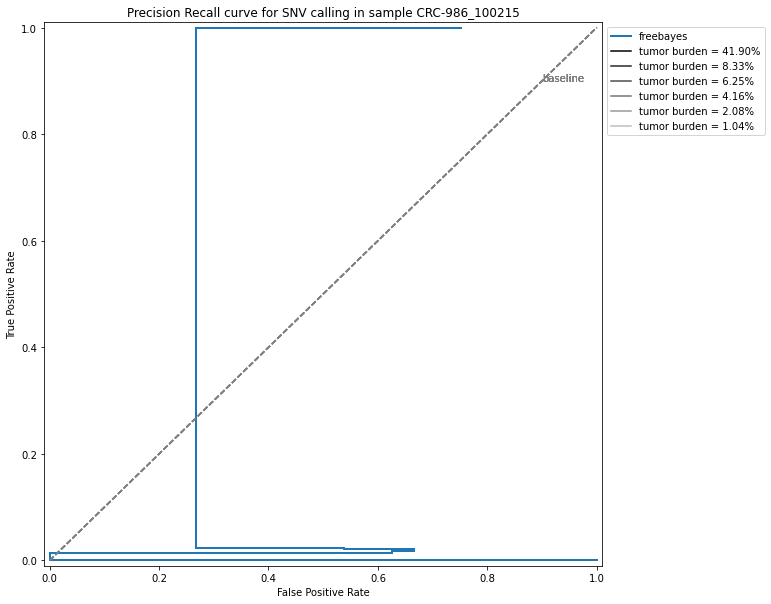

In [10]:
# Sample of interest
fig, ax = plt.subplots(figsize=(10,10))
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
for i, d in enumerate(dilutionseries):
    #if i == 0:
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    print('vcf_pd_'+str(i), d)
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
    if vcf_sample is not None:
        vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
        print(vcf_sample.shape)

        for method in config.methods:
            # GROUND TRUTH = calls detected by same method in undiluted sample
            y_true = pd.DataFrame(vcf_ref[[method]])
            y_true.columns = ['truth']
            y_true = y_true.astype(bool)
            df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

            df_sample_method = df_sample[['truth', method + '_score']].dropna(how='all')
            df_sample_method['truth'].fillna(False, inplace=True)
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            fpr, tpr, thresholds = roc_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
            if i == 0:
                plot_roc_curve(precision, recall, estimator_name=method, auc_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
            else:
                plot_roc_curve(precision, recall, estimator_name='', auc_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
handles, labels = plt.gca().get_legend_handles_labels()
# Creating legend with color box
list_lines =  handles + [Line2D([0], [0], color='black', alpha=alpha_dict[str(i)], label='tumor burden = {:.2f}%'.format(100*tb_dict[str(i)])) for i in dilutionseries]
plt.legend(bbox_to_anchor=(1,1), loc="upper left", handles=list_lines)
plt.title("Receiving Operator Characteristic curve for SNV calling in sample {}".format(plasmasample1))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

In [30]:
vcf_ref.head()

,CHROM,POS,REF,ALT,QUAL,freebayes,type,freebayes_score,mutect2,mutect2_score,vardict,vardict_score,varscan,varscan_score
CHROM_POS,,,,,,,,,,,,,,
22_16050252,22,16050252.0,A,T,263.82,True,SNV,0.923496,NaN,NaN,True,0.02733,NaN,NaN
22_16055570,22,16055570.0,T,C,312.633,True,SNV,0.911903,NaN,NaN,NaN,NaN,NaN,NaN
22_16060744,22,16060744.0,G,C,590.86,True,SNV,0.960858,True,0.98937,True,0.00006,NaN,NaN
22_16067349,22,16067349.0,A,G,21.9469,True,SNV,0.834630,NaN,NaN,NaN,NaN,NaN,NaN
22_16067375,22,16067375.0,G,A,195.185,True,SNV,0.940104,NaN,NaN,NaN,NaN,NaN,NaN


(1373, 1)
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(340, 14) (1373, 1)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(153, 14) (1373, 1)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(149, 14) (1373, 1)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(146, 14) (1373, 1)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(148, 14) (1373, 1)


(-0.01, 1.01)

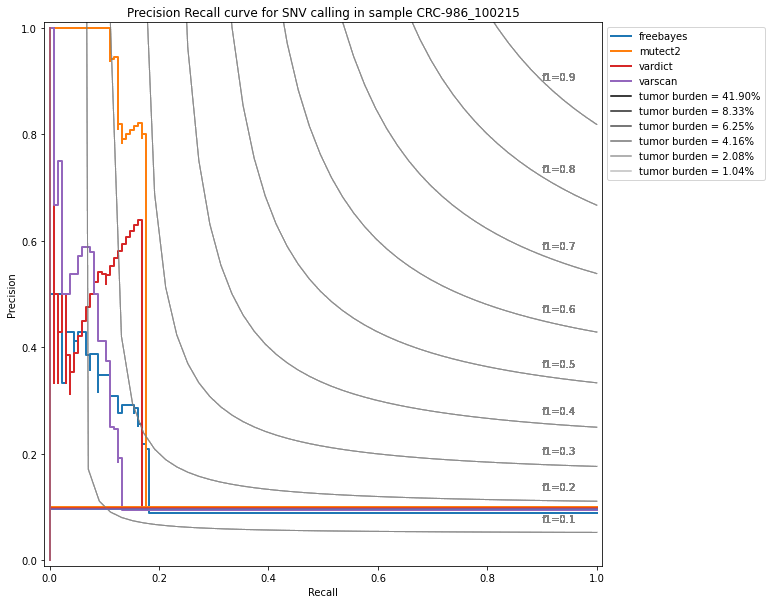

In [34]:
# GROUND TRUTH = consensus across 3 callers in undiluted sample
#vcf_path = os.path.join(*bcbiooutputdirpath, tumorsample1, tumorsample1+"-ensemble-annotated.vcf")
#vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
#vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[config.methods_tissue].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)

# Sample of interest
fig, ax = plt.subplots(figsize=(10,10))
for i, d in enumerate(dilutionseries):
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    print('vcf_pd_'+str(i), d)
    vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
    vcf_sample = load_calls_from_vcf(vcf_path, config.methods_tissue, chrom=chrom)
    if vcf_sample is not None:
        vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
        print(vcf_sample.shape, y_true.shape)
        df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

        for method in config.methods_tissue:
            df_sample_method = df_sample[['truth', method + '_score']].dropna(how='all')
            #print(df_sample_method.shape)
            df_sample_method['truth'].fillna(False, inplace=True)
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            precision, recall, thresholds = precision_recall_curve(df_sample_method['truth'], df_sample_method[method + '_score'])
            if i == 0:
                plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[str(d)], 'lw':2})
            else:
                plot_pr_curve(precision, recall, estimator_name='', f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha': alpha_dict[str(d)], 'lw':2})
handles, labels = plt.gca().get_legend_handles_labels()
# Creating legend with color box
list_lines =  handles + [Line2D([0], [0], color='black', alpha=alpha_dict[str(i)], label='tumor burden = {:.2f}%'.format(100*tb_dict[str(i)])) for i in dilutionseries]
plt.legend(bbox_to_anchor=(1,1), loc="upper left", handles=list_lines)
plt.title("Precision Recall curve for SNV calling in sample {}".format(plasmasample1))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(132, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(138, 16)
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
(132, 16)
vcf_pd_4 (0.25, 0.855)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.25_pooledhealthy_986_filter_snv_0.855/dilution_chr22_CRC-986_100215_0_25_pooledhealthy_986_filter_snv_0_855-ensemble-annotated.vcf
vcf_pd_5 (0.125, 0.875)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.125_pooledhealthy_986_filter_snv_0.875/dilution_chr22_CRC-986_100215_0_125_pooledhealthy_986_filter_snv_0_875-ensemble-annotated.vcf


Text(0.5, 1.0, 'Precision curve for SNV calling in sample CRC-986_100215')

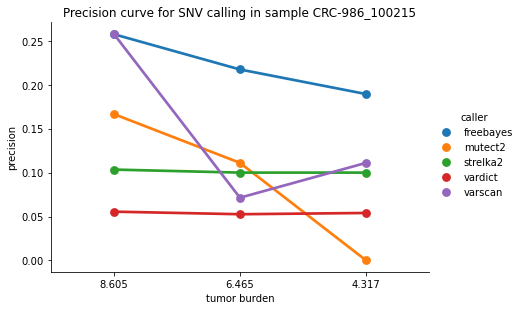

In [33]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(precision_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['precision'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="precision", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("Precision curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(132, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(138, 16)
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
(132, 16)
vcf_pd_4 (0.25, 0.855)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.25_pooledhealthy_986_filter_snv_0.855/dilution_chr22_CRC-986_100215_0_25_pooledhealthy_986_filter_snv_0_855-ensemble-annotated.vcf
vcf_pd_5 (0.125, 0.875)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.125_pooledhealthy_986_filter_snv_0.875/dilution_chr22_CRC-986_100215_0_125_pooledhealthy_986_filter_snv_0_875-ensemble-annotated.vcf


Text(0.5, 1.0, 'Recall curve for SNV calling in sample CRC-986_100215')

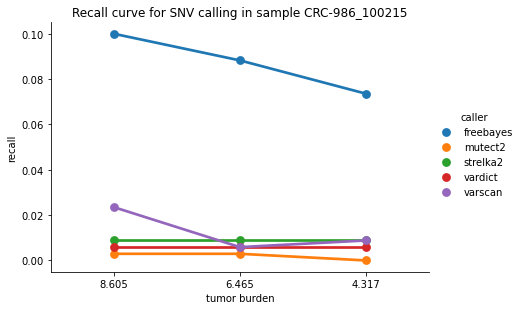

In [31]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(recall_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['recall'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="recall", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("Recall curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

# F1-score plot

select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(132, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(138, 16)
vcf_pd_3 (0.5, 0.81)
select a single chrom = 22 for analysis
(132, 16)
vcf_pd_4 (0.25, 0.855)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.25_pooledhealthy_986_filter_snv_0.855/dilution_chr22_CRC-986_100215_0_25_pooledhealthy_986_filter_snv_0_855-ensemble-annotated.vcf
vcf_pd_5 (0.125, 0.875)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.125_pooledhealthy_986_filter_snv_0.875/dilution_chr22_CRC-986_100215_0_125_pooledhealthy_986_filter_snv_0_875-ensemble-annotated.vcf


Text(0.5, 1.0, 'F1-score curve for SNV calling in sample CRC-986_100215')

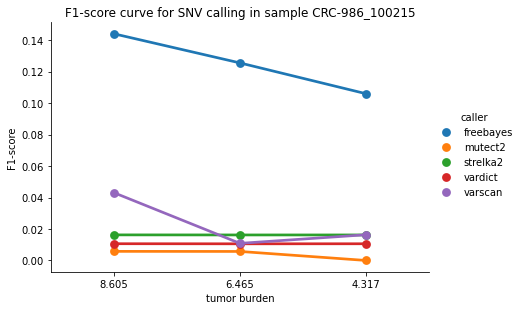

In [34]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_precision = []
aux_method = []
aux_sample = []
aux_tb = []

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method]])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

                df_sample_method = df_sample[['truth', method]].dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method].fillna(False, inplace=True)
                aux_precision.append(f1_score(df_sample_method['truth'], df_sample_method[method]))
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['F1-score'] = aux_precision
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="F1-score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("F1-score curve for SNV calling in sample {}".format(plasmasample1))
#plt.ylim([-0.01, 1.01])

# AUPRC plot

select a single chrom = 22 for analysis
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(153, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(149, 16)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(146, 16)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(148, 16)


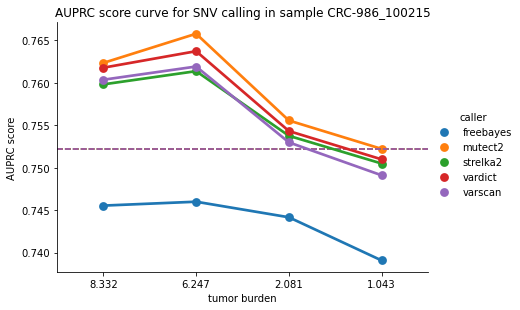

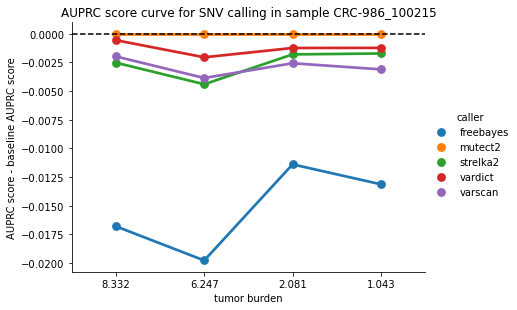

In [22]:
# Sample of interest
# GROUND TRUTH = calls detected by same method in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']

results_df = pd.DataFrame()
aux_auprc = []
aux_auprcrelative = []
aux_method = []
aux_sample = []
aux_tb = []

baselineAUPRC = {}

for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape)

            for method in config.methods:
                # GROUND TRUTH = calls detected by same method in undiluted sample
                y_true = pd.DataFrame(vcf_ref[[method+'_score']])
                y_true.columns = ['truth']
                y_true = y_true.astype(bool)
                df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis
                
                df_sample_method = df_sample[['truth', method+'_score']]#.dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method+'_score'].fillna(0, inplace=True)
                baselineAUPRC[method] = df_sample_method['truth'][df_sample_method['truth'] == True].shape[0]/df_sample_method['truth'].shape[0]
                aux_auprc.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']))
                aux_auprcrelative.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']) - baselineAUPRC[method])
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['AUPRC score'] = aux_auprc
results_df['AUPRC score - baseline AUPRC score'] = aux_auprcrelative
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
for method in config.methods:
    plt.axhline(y = baselineAUPRC[method], color = color_dict[method], linestyle = '--') 
sns.catplot(x="tumor burden", y="AUPRC score - baseline AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
plt.axhline(y = 0, color = 'k', linestyle = '--') 
#plt.ylim([-0.01, 1.01])

select a single chrom = 22 for analysis
(340, 1)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(153, 16) (340, 1)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(149, 16) (340, 1)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-986_100215_0.5_pooledhealthy_0.81/dilution_chr22_CRC-986_100215_0_5_pooledhealthy_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(146, 16) (340, 1)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(148, 16) (340, 1)


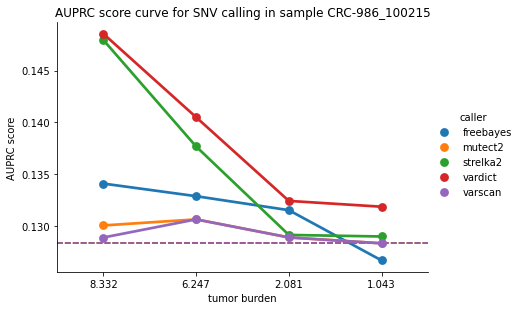

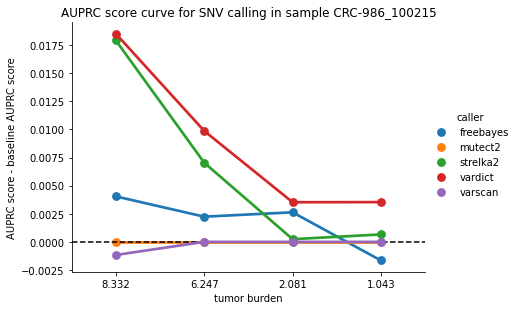

In [24]:

results_df = pd.DataFrame()
aux_auprc = []
aux_auprcrelative = []
aux_method = []
aux_sample = []
aux_tb = []

baselineAUPRC = {}

# GROUND TRUTH = consensus across 3 callers in undiluted sample
vcf_path = os.path.join(*bcbiooutputdirpath, prefix + plasmasample1 + "_1_"+reference+"_0", prefix + plasmasample1 + "_1_"+reference+"_0-ensemble-annotated.vcf")
vcf_ref = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
vcf_ref = vcf_ref[vcf_ref['type'] == 'SNV']
y_true = pd.DataFrame(vcf_ref[methods].T.sum())
y_true.columns = ['truth']
y_true['truth'][y_true['truth'] < 3] = 0
y_true = y_true.astype(bool)
print(y_true.shape)

# Sample of interest
for i, d in enumerate(dilutionseries):
    if i != 0:
        d0 = str(d[0]).replace('.', '_')
        d1 = str(d[1]).replace('.', '_')
        print('vcf_pd_'+str(i), d)
        vcf_path = os.path.join(*bcbiooutputdirpath, prefix+plasmasample1+"_"+str(d[0])+"_"+reference+"_"+str(d[1]), prefix+plasmasample1+"_"+d0+"_"+reference+"_"+d1+"-ensemble-annotated.vcf")
        vcf_sample = load_calls_from_vcf(vcf_path, methods, chrom=chrom)
        if vcf_sample is not None:
            vcf_sample = vcf_sample[vcf_sample['type'] == 'SNV']
            print(vcf_sample.shape, y_true.shape)
            df_sample = vcf_sample.join(y_true, how='outer') # not concat because duplicated axis

            for method in config.methods:
                df_sample_method = df_sample[['truth', method+'_score']]#.dropna(how='all')
                df_sample_method['truth'].fillna(False, inplace=True)
                df_sample_method[method+'_score'].fillna(0, inplace=True)
                baselineAUPRC[method] = df_sample_method['truth'][df_sample_method['truth'] == True].shape[0]/df_sample_method['truth'].shape[0]
                aux_auprc.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']))
                aux_auprcrelative.append(average_precision_score(df_sample_method['truth'], df_sample_method[method+'_score']) - baselineAUPRC[method])
                aux_method.append(method)
                aux_tb.append(round(100*tb_dict[str(d)], 3))

results_df['AUPRC score'] = aux_auprc
results_df['AUPRC score - baseline AUPRC score'] = aux_auprcrelative
results_df['tumor burden'] = aux_tb
results_df['caller'] = aux_method
sns.catplot(x="tumor burden", y="AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
for method in config.methods:
    plt.axhline(y = baselineAUPRC[method], color = color_dict[method], linestyle = '--') 
sns.catplot(x="tumor burden", y="AUPRC score - baseline AUPRC score", hue="caller", capsize=.2, height=4, aspect=1.5, kind="point", order=sorted(results_df['tumor burden'].unique(), reverse=True), data=results_df)
plt.title("AUPRC score curve for SNV calling in sample {}".format(plasmasample1))
plt.axhline(y = 0, color = 'k', linestyle = '--') 
#plt.ylim([-0.01, 1.01])